In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [7]:
# *** Specify directories files for input and output *** #
openDir = 'input'
saveDir = 'output\\'

saveCal = 'testCalCurve.xlsx'
saveStds = 'testStandardsCalc.xlsx'
saveSam = 'testSamplesCalc.xlsx'
# *** End directories /files for input and output *** #

#---- Do not change anything below this line ----#
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

def step1(PE0, PEt, t):
    # calculates the ke value
    return np.log(PE0/PEt)/t

# fucntion fit
def step2(logKPE, n, kf):
    return (n*logKPE)+kf

def step2nl(KPE, n, kf):
    return kf*(KPE**n)

def step4(Ke, t):
    return 1/(1+np.exp(-Ke*t))

In [8]:
# *** Specify excel for input *** #
refs = pd.read_excel(openDir + '\\testInputData.xlsx', sheet_name='sampleRef')
stds = pd.read_excel(openDir + '\\testInputData.xlsx', sheet_name='standards')
samples = pd.read_excel(openDir + '\\testInputData.xlsx', sheet_name='samples')
chemRef = pd.read_excel(openDir + '\\testInputData.xlsx', sheet_name='chemRef')
# *** End Specify excel for input *** #

#---- Do not change anything below this line ----#
kpeRef_log = dict(zip(chemRef['Analyte'].str.strip(), chemRef['log KPE_L/kg-PE']))
kpeRef = dict(zip(chemRef['Analyte'].str.strip(), chemRef['KPE_L/kg-PE']))
avgBlankRef = dict(zip(chemRef['Analyte'].str.strip(), chemRef['avgTripBlank']))


# Create cal curves for the site specific data

S1 50
S2 10
S3 25


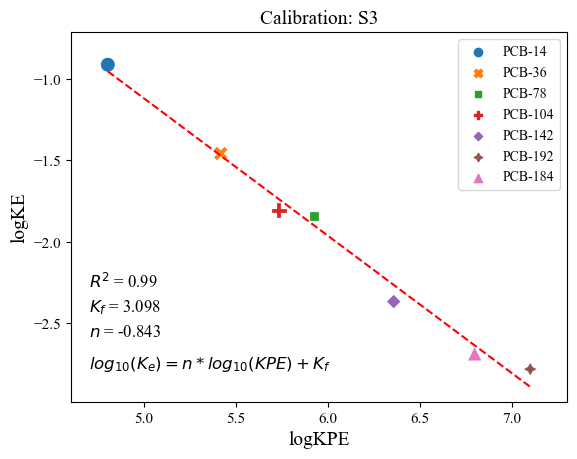

In [9]:
#---- Do not change anything below this line ----#
plt.rcParams["font.family"] = "Times New Roman"

# Initialize the ke and KPE data frames
stds['avgTripBlank'] = np.zeros(len(stds.index))
stds['Ke'] = np.zeros(len(stds.index))
samples['Ke'] = np.zeros(len(samples.index))
stds['logKE'] = np.zeros(len(stds.index))
samples['logKE'] = np.zeros(len(samples.index))
stds['KPE'] = np.zeros(len(stds.index))
samples['KPE'] = np.zeros(len(samples.index))
stds['logKPE'] = np.zeros(len(stds.index))
samples['logKPE'] = np.zeros(len(samples.index))

# Initialize the KPE dataframes
stds['avgTripBlank'] = stds['Analyte'].str.strip().map(avgBlankRef)
stds['KPE'] = stds['Analyte'].str.strip().map(kpeRef)
stds['logKPE'] = stds['Analyte'].str.strip().map(kpeRef_log)
samples['KPE'] = samples['Analyte'].str.strip().map(kpeRef)
samples['logKPE'] = samples['Analyte'].str.strip().map(kpeRef_log)

calCurve = pd.DataFrame(columns=['Sample', 'time','kf','n', 'R2'])

for i, t in zip(refs['Sample'].str.strip().to_list(), refs['elapsedTime_days'].to_list()):
    # check times
    print(i, t)
    # initialize sample calibration
    dStd = stds[stds['Sample'].str.strip() == i]
    # dSam = samples[samples['Sample'].str.strip().contains(i)]

    #---- Do step 1 of the method ----#
    stdKe = step1(np.array(dStd['Result_ng/g']), np.array(dStd['avgTripBlank']), t)

    # StdKe is the degradation constant, store here
    stds.loc[stds['Sample'] == i, 'Ke'] = stdKe

    # Convert to log of the negative degradation constant (i.e. deg constant is inherently negative)
    logStdKe = np.log10(-stdKe)
    # Replace any remaining negative values with nan, indicative of blank which are greater than measured
    logStdKe[np.isinf(logStdKe)] = np.nan
    stds.loc[stds['Sample'] == i, 'logKE'] = logStdKe
    # store data and use warning cather to supress warning output
    with warnings.catch_warnings(record=True):
        dStd.loc[:,'logKE'] = logStdKe

    # drop na values from dummy array for step 2
    dStd = dStd.dropna(subset=['logKE'])

    #---- Do step 2 ----#
    popt, pcov = curve_fit(step2, xdata=np.array(dStd['logKPE']), ydata=np.array(dStd['logKE']))
    predKe_log = step2(np.array(dStd['logKPE']), popt[0], popt[1])
    R2 = r_squared(np.array(dStd['logKE']), predKe_log)

    # # If R squared does not meed minimum requirement remove outliers
    if R2 < 0.98:
        dStd['diff'] = np.abs(np.array(dStd['logKE']) - predKe_log)
        dStd = dStd[dStd['diff'] < 0.25]
        popt, pcov = curve_fit(step2, xdata=np.array(dStd['logKPE']), ydata=np.array(dStd['logKE']))
        predKe_log = step2(np.array(dStd['logKPE']), popt[0], popt[1])
        R2 = r_squared(np.array(dStd['logKE']), predKe_log)

        # One last attempt to get better R2 if still does not meet standards
        if R2 < 0.98:
            dStd['diff'] = np.abs(np.array(dStd['logKE']) - predKe_log)
            dStd = dStd[dStd['diff'] < 0.15]
            popt, pcov = curve_fit(step2, xdata=np.array(dStd['logKPE']), ydata=np.array(dStd['logKE']))
            predKe_log = step2(np.array(dStd['logKPE']), popt[0], popt[1])
            R2 = r_squared(np.array(dStd['logKE']), predKe_log)

    # Create fitted line
    ex = np.linspace(dStd['logKPE'].min(), dStd['logKPE'].max(), 50)
    why = step2(ex, popt[0], popt[1])

    # Make the figure and save to the appropriate directory
    plt.close()
    fig, ax = plt.subplots()
    sns.scatterplot(data=dStd, x = 'logKPE', y = 'logKE', hue='Analyte', style='Analyte', s=120, ax=ax)
    ax.legend(loc='upper right', frameon = True, framealpha = 0.75)
    ax.plot(ex, why, 'r--')
    x_min = dStd['logKPE'].min()-0.2
    x_max = dStd['logKPE'].max()+0.2
    y_min = dStd['logKE'].min()-0.2
    y_max = dStd['logKE'].max()+0.2
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.text(x_min + 0.1, y_min +0.7, r'$R^2$ = %s' % (round(R2, 2)), fontsize = 12)
    ax.text(x_min + 0.1, y_min +0.55, r'$K_{f}$ = %s' % (round(popt[1], 3)), fontsize = 12)
    ax.text(x_min + 0.1, y_min +0.4, r'$n$ = %s' % (round(popt[0], 3)), fontsize = 12)
    ax.text(x_min + 0.1, y_min +0.2, r'$log_{10}(K_{e}) = n*log_{10}(KPE)+K_{f}$', fontsize = 12)
    ax.set_title('Calibration: ' + i, fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_xlabel('logKPE', fontsize = 14)
    ax.set_ylabel('logKE', fontsize = 14)
    plt.savefig(saveDir + i + '_calibration.png', bbox_inches = 'tight', dpi = 200)

    #---- Step 3 does not apply ----#

    # create calCurve File
    dCal = pd.DataFrame([[i, t, round(popt[1],3), round(popt[0],3), round(R2, 3)]], columns=['Sample', 'time','kf','n', 'R2'])
    calCurve = pd.concat([calCurve, dCal], ignore_index=True)

calCurve.to_excel(saveDir + saveCal)


# Start samples processing

In [10]:
stds['CF'] = np.zeros(len(stds.index))
samples['CF'] = np.zeros(len(samples.index))
stds['eqConc'] = np.zeros(len(stds.index))
samples['eqConc'] = np.zeros(len(samples.index))
stds['cFree'] = np.zeros(len(stds.index))
samples['cFree'] = np.zeros(len(samples.index))
for i, t in zip(refs['Sample'].str.strip().to_list(), refs['elapsedTime_days'].to_list()):
    dCal = calCurve[calCurve['Sample'].str.strip() == i]
    dStd = stds[stds['Sample'].str.strip() == i]
    dSam = samples[samples['Sample'].str.strip() == i]

    kf = float(dCal['kf'])
    n = float(dCal['n'])
    
    logSamKe = step2(dSam['logKPE'].to_numpy(), n, kf)
    samples.loc[samples['Sample'] == i, 'logKE'] = logSamKe
    samples.loc[samples['Sample'] == i, 'Ke'] = -1*(10**(logSamKe))
    
    samKe = 10**logSamKe

    # Do step 4
    stdCF = step4(dStd['Ke'].to_numpy(), t)
    samCF = step4(samKe, t)

    stds.loc[stds['Sample'] == i, 'CF'] = stdCF
    samples.loc[samples['Sample'] == i, 'CF'] = samCF

    # Do step 5
    stds.loc[stds['Sample'] == i, 'eqConc'] = stdCF*stds.loc[stds['Sample'] == i, 'Result_ng/g'].to_numpy()
    samples.loc[samples['Sample'] == i, 'eqConc'] = samCF*samples.loc[samples['Sample'] == i, 'Result_ng/g'].to_numpy()

    # Do step 6
    
    stds.loc[stds['Sample'] == i, 'cFree'] = stds.loc[stds['Sample'] == i, 'Result_ng/g'].to_numpy()/stds.loc[stds['Sample'] == i, 'KPE'].to_numpy()
    samples.loc[samples['Sample'] == i, 'cFree'] = samples.loc[samples['Sample'] == i, 'Result_ng/g'].to_numpy()/samples.loc[samples['Sample'] == i, 'KPE'].to_numpy()

stds.to_excel(saveDir + saveStds)
samples.to_excel(saveDir + saveSam)
    
    

# Done with sirem fitting